## FINAL MODEL 

Polaczenie LightBgm z RandomForest za pomoca soft VoteClassifiera

In [2]:
from ColumnTransformers import * 
from AdvModels import *
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,precision_score,accuracy_score,recall_score

Funkcje przygotowujące każdy ze składowych modeli z osobna, ostateczny model (VoteClassifier) i rysujące wykres z SHAP
Przy użyciu selektorów cech każdy z tych modeli pracuje na 18 najbardziej znaczących cechach

In [3]:
def LGBMClassifierPipeline(): 
    model=LGBMClassifier(
        colsample_bytree=0.8,
        is_unbalance=True,
        learning_rate=0.01,
        max_depth=2,
        min_split_gain=0.1,
        n_estimators=600,
        reg_lambda=1,
        subsample=1,
        verbosity=-1,
        random_state=42
    )
    result=PipelineModel(model,n=18)
    return result

def RandomForestClassifierPipeline(): 
    model=RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=10,
        max_features=0.5,
        max_depth=8,
        class_weight="balanced",
        random_state=42
    ) 
    result=PipelineModel(model,n=18)
    return result
        

def create_voting_classifier():
    randomforest_pipeline = RandomForestClassifierPipeline()
    lgbm_pipeline = LGBMClassifierPipeline() 
    print(type(lgbm_pipeline))
    voting_ensemble = VotingClassifier(
        estimators=[
            ('randomforest', randomforest_pipeline),
            ('lgbm',     lgbm_pipeline)
        ],
        voting='soft'
    )
    return voting_ensemble

def lgbmImportanceGetter(X_train,y_train): 
    pipeline=LGBMClassifierPipeline() 
    pipeline.fit(X_train,y_train)
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

    selector = pipeline.named_steps["featureselection"]
    support_mask = selector.support_
    selected_features = feature_names[support_mask]

    model = pipeline.named_steps["model"]
    importances = model.feature_importances_  
    feature_importance_df = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    return feature_importance_df

def plotShap(model,X_train,y_train):

    model.fit(X_train,y_train)
 
    prep_and_rfe = model[:-1]                
    lgbm         = model.named_steps["model"] 
    X_train_t = prep_and_rfe.transform(X_train)     

    feature_names = prep_and_rfe.get_feature_names_out()


    explainer   = shap.TreeExplainer(lgbm)
    shap_values = explainer(X_train_t)
    shap.summary_plot(
    shap_values,
    features      = X_train_t,
    feature_names = feature_names,
    plot_size     = (20, 14)       
    )
    plt.show() 


Funkcja testująca pojedynczy model

In [4]:
def TestingModel(Model,X_train,X_test,y_train,y_test,threshold): 
    
    Model.fit(X_train,y_train) 
    y_scores=Model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr,roc_auc)

    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred,y_test)
    print(f"AUC: {roc_auc}, Recall: {recall_score(y_test,y_pred)}")
    RecallTresholdPlot(y_scores,y_test)
    return Model
def RecallTresholdPlot(y_predict_proba,y_final): 
    tresholds=np.arange(0,1,0.01)
    RecallVector=np.zeros(100)
    F1Vector=np.zeros(100)
    PrecisionVector=np.zeros(100)
    AccuracyVector=np.zeros(100)
    for i in range(len(tresholds)): 
        y_pred=np.array(y_predict_proba>tresholds[i])
        RecallVector[i]=recall_score(y_final,y_pred)
        F1Vector[i]=f1_score(y_final,y_pred)
        PrecisionVector[i]=precision_score(y_final,y_pred)
        AccuracyVector[i]=accuracy_score(y_final,y_pred)
   
    
    fig, axs = plt.subplots(2, 2,figsize=(16, 10))
    axs[0,0].plot(tresholds,RecallVector) 
    axs[0,0].set_title("RECALL") 
    axs[0,0].grid() 
    
    axs[1,0].plot(tresholds,F1Vector) 
    axs[1,0].set_title("F1") 
    axs[1,0].grid() 
    
    axs[0,1].plot(tresholds,PrecisionVector) 
    axs[0,1].set_title("PRECISION")
    axs[0,1].grid() 
    
    axs[1,1].plot(tresholds,AccuracyVector) 
    axs[1,1].set_title("ACCURACY")
    axs[1,1].grid() 
    plt.show()

Stworzenie finalnego modelu i ewaluacja jego pracy

In [5]:
def FinalModel(X_train,X_test,y_train,y_test,threshold=0.5): 
    finalModel=create_voting_classifier()
    set_config(display='diagram')
    display(finalModel)
    finalModel.fit(X_train,y_train)
    y_scores=finalModel.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr,roc_auc)
    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred,y_test)
    print(f"AUC: {roc_auc}")
    return finalModel

In [6]:
def getTrainingData():
    df =pd.read_csv("../data/TrainData.csv")
    X = df.drop(columns=["Is.Fraudulent"]).copy()
    y = df["Is.Fraudulent"].copy()
    return X,y
def getTestData():
    df=pd.read_csv("../data/TestData.csv")
    X = df.drop(columns=["Is.Fraudulent"]).copy()
    y = df["Is.Fraudulent"].copy()
    return X,y
    
def getValidationData():
    df=pd.read_csv("../data/ValidationData.csv")
    X = df.drop(columns=["Is.Fraudulent"]).copy()
    y = df["Is.Fraudulent"].copy()
    return X,y

In [7]:
X_train,y_train=getTrainingData()
X_test,y_test=getTestData()

## Performance oddzielnych modeli

In [7]:
lgbm = LGBMClassifierPipeline()
randomforest = RandomForestClassifierPipeline()

C:\Users\Ricardo\Programming\PycharmProjects\ML_Intro-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


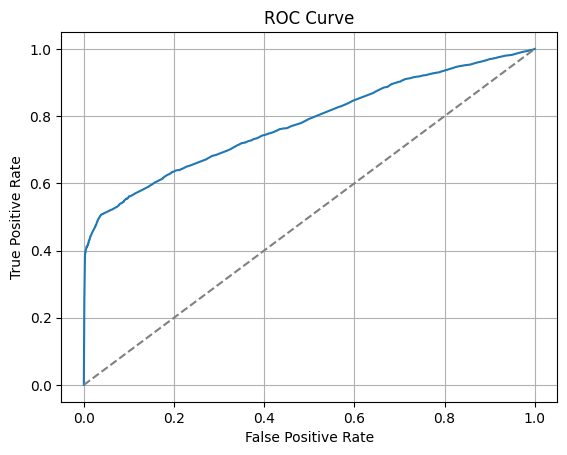

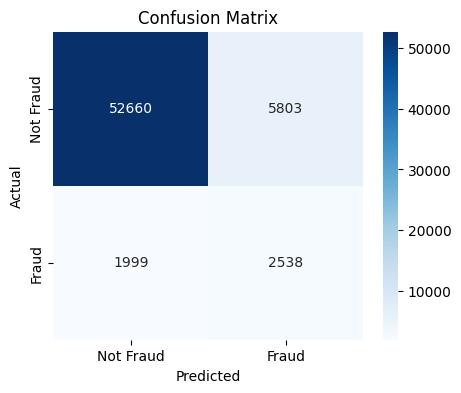

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     58463
           1       0.30      0.56      0.39      4537

    accuracy                           0.88     63000
   macro avg       0.63      0.73      0.66     63000
weighted avg       0.92      0.88      0.89     63000

AUC: 0.7787159585073109, Recall: 0.5594004849019175


C:\Users\Ricardo\Programming\PycharmProjects\ML_Intro-Projects\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


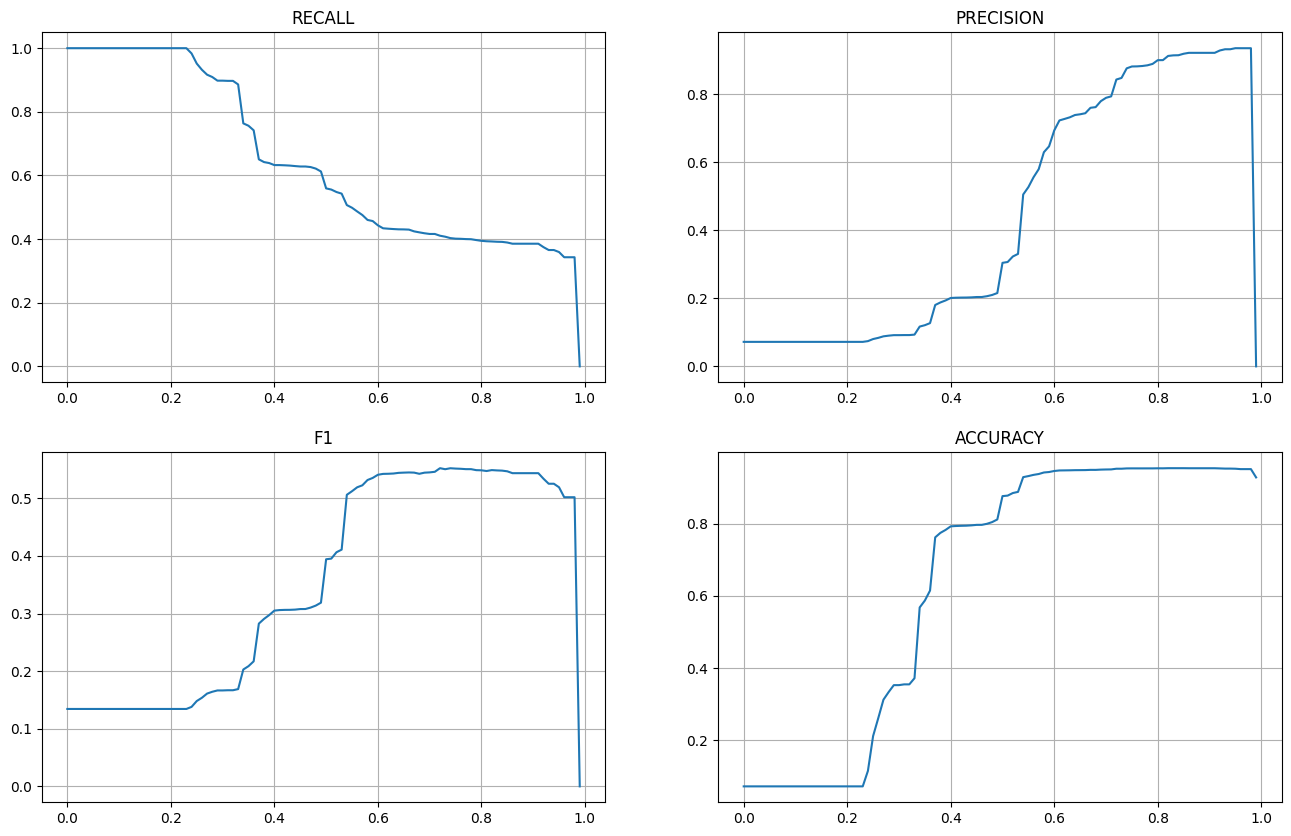

,Feature,Importance
7,numerical__Account.Age.Days,712
6,numerical__Transaction.Amount,465
0,time_features__FirstPartMonth,370
5,high_amount__Is.HighAmount,42
3,time_features__Transaction.Weekday_3,36
2,time_features__Transaction.Weekday_2,13
13,catBasic__browser_IE,13
16,catBasic__source_Ads,11
12,catBasic__browser_FireFox,8
14,catBasic__browser_Opera,8


In [29]:
TestingModel(lgbm,X_train,X_test,y_train,y_test,threshold=0.5)
lgbmImportanceGetter(X_train,y_train)

Dla LGBM największe znaczenie mają:
* długość istnienia konta,
* informacja, czy transakcja została dokonana w pierwszych 12 dniach miesiąca,
* wysokość kwoty transakcji

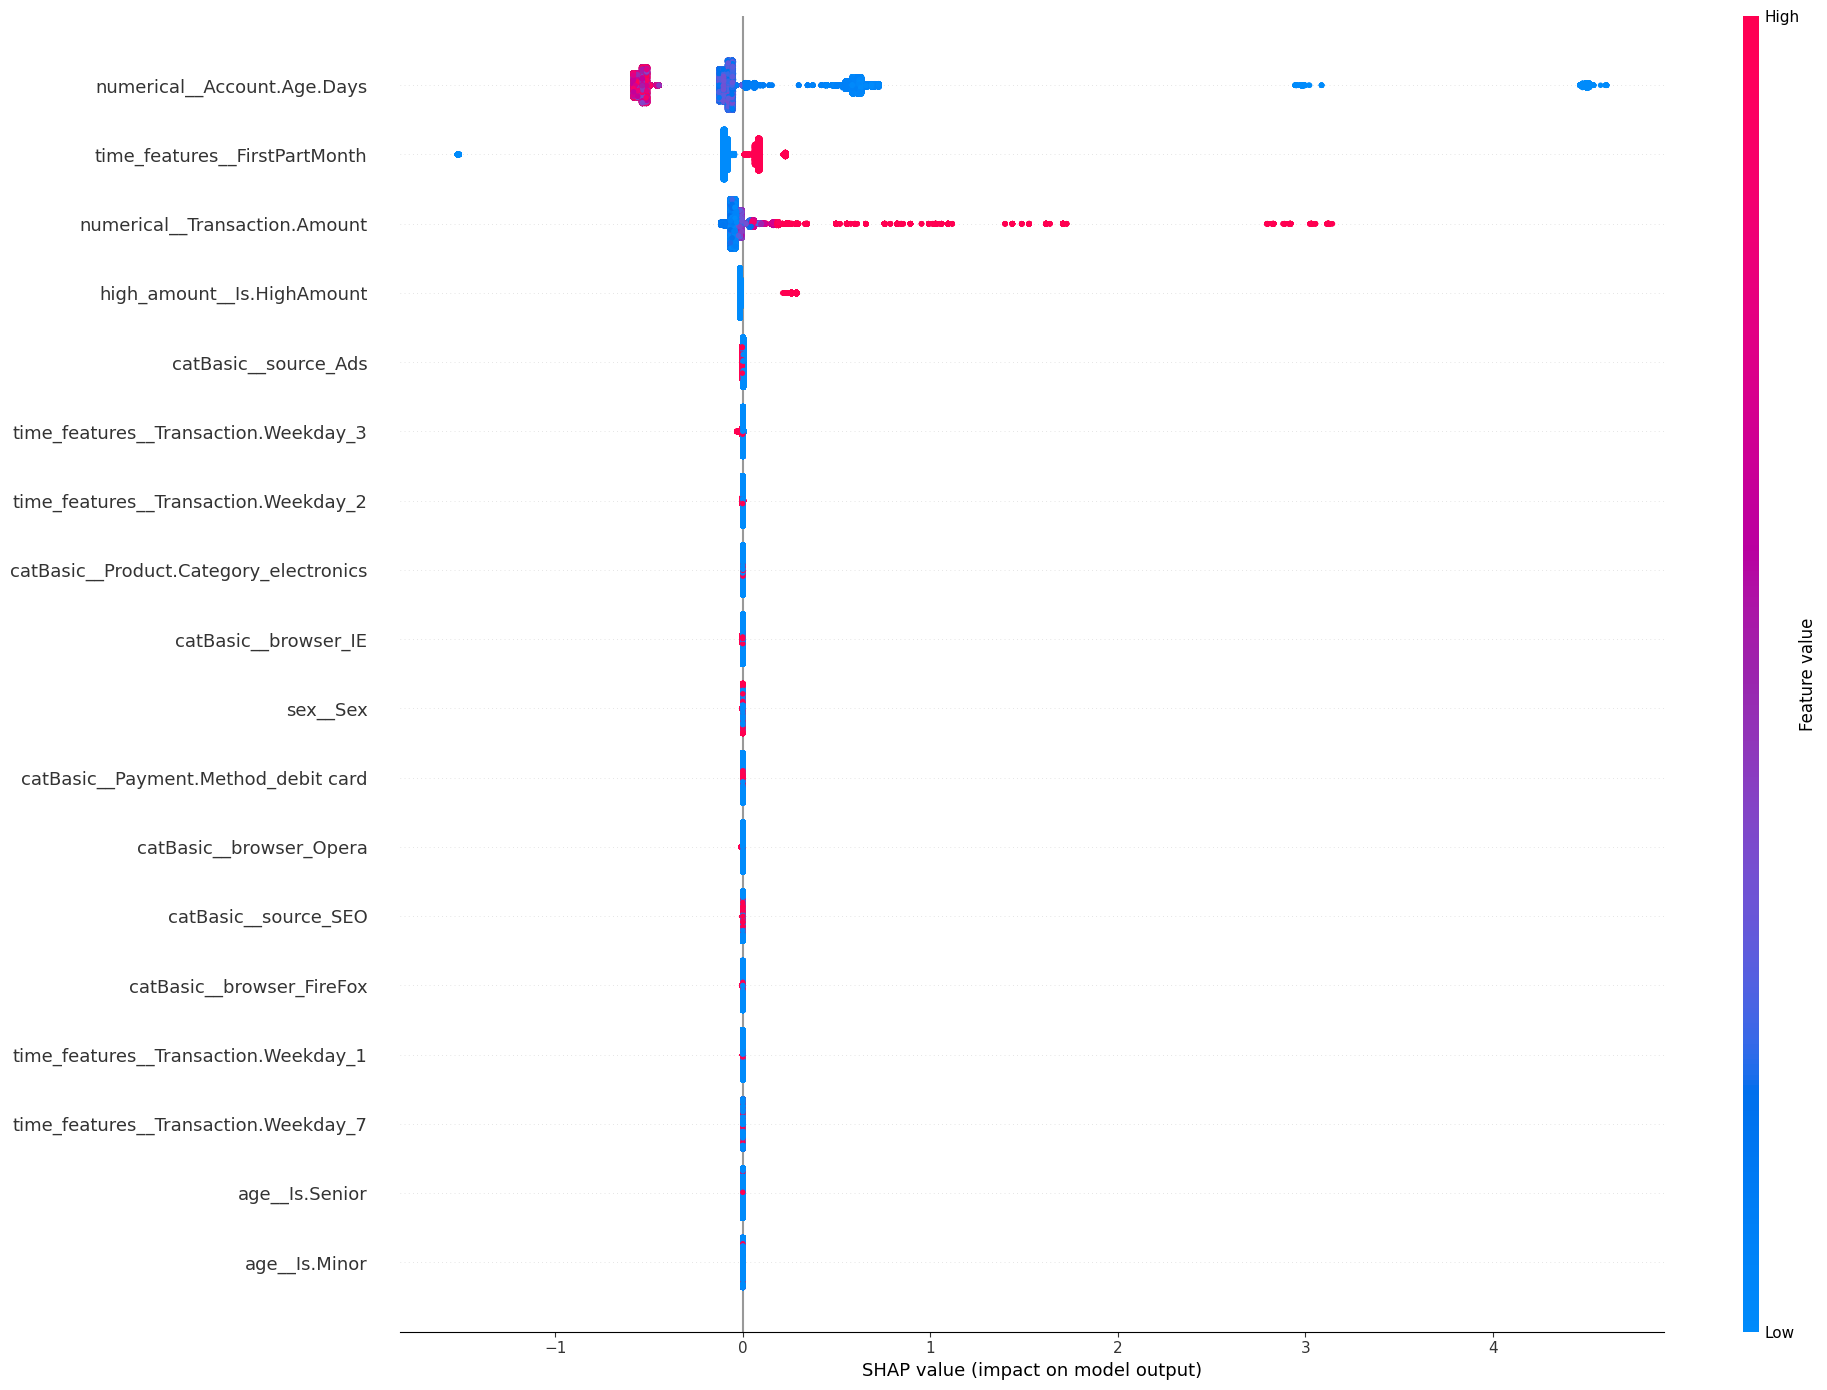

In [30]:
plotShap(lgbm,X_train,y_train)

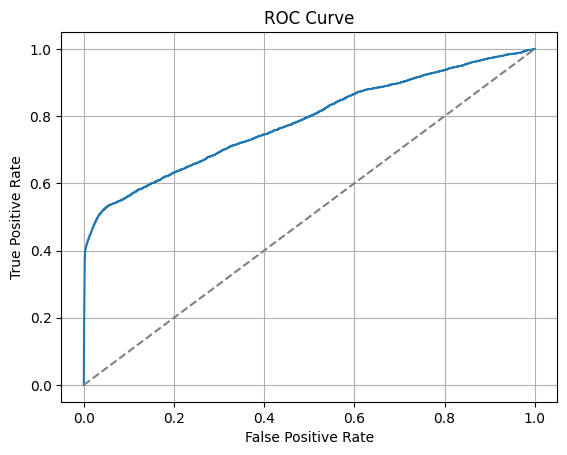

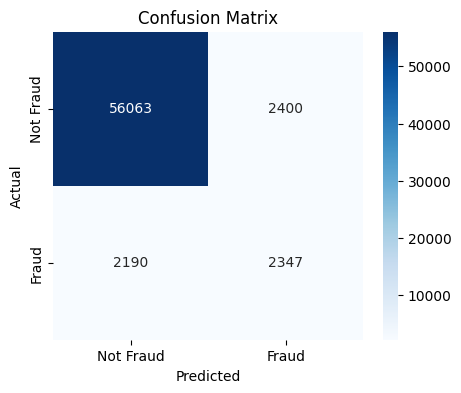

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     58463
           1       0.49      0.52      0.51      4537

    accuracy                           0.93     63000
   macro avg       0.73      0.74      0.73     63000
weighted avg       0.93      0.93      0.93     63000

AUC: 0.7836116719612549, Recall: 0.5173021820586291


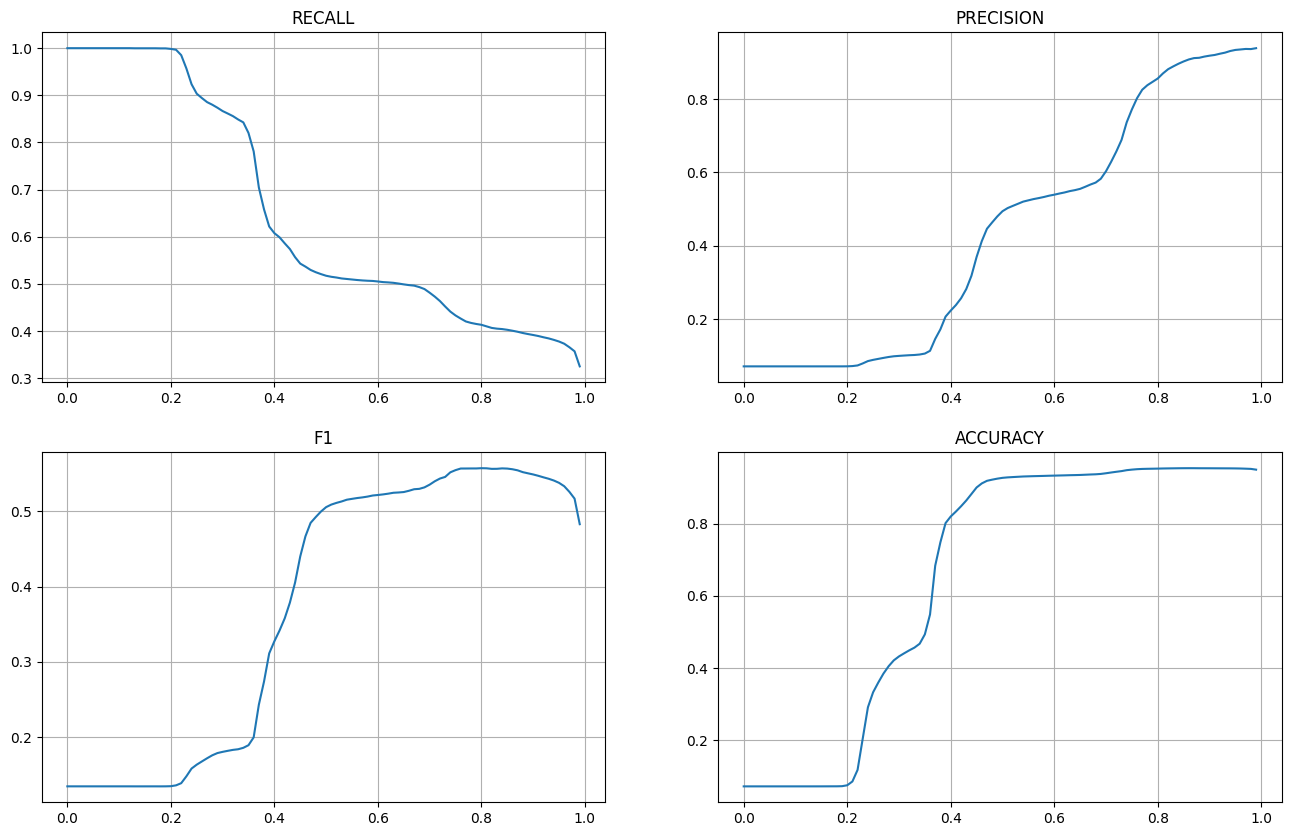

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=18)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        max_features=0.5, min_samples_leaf=10,
                                        min_samples_split=5, n_estimators=200,
                                        random_state=42))])

In [31]:
TestingModel(randomforest,X_train,X_test,y_train,y_test,threshold=0.5)

(Z jakiegoś powodu shap w tym przypadku nie działa)
Dla RandomForest, tak jak dla LGBM, największe znaczenie mają:
* długość istnienia konta,
* informacja, czy transakcja została dokonana w pierwszych 12 dniach miesiąca,
* wysokość kwoty transakcji

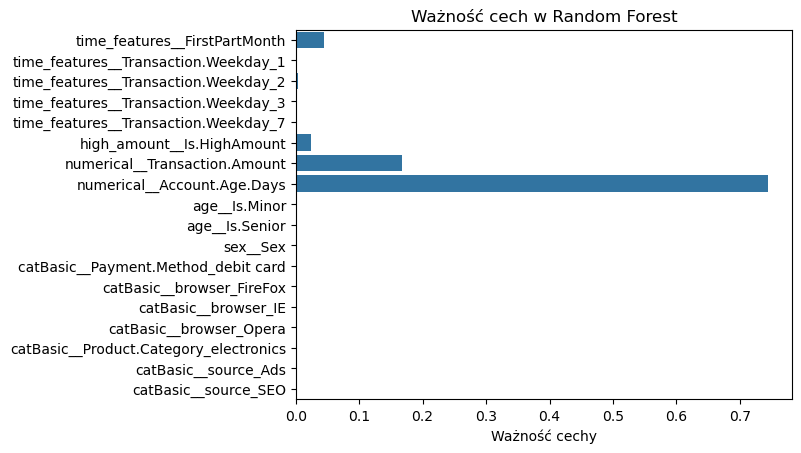

In [8]:
randomforest.fit(X_train,y_train)
importances = randomforest.named_steps["model"].feature_importances_

prep_and_rfe = randomforest[:-1]                
feature_names = prep_and_rfe.get_feature_names_out()

import matplotlib.pyplot as plt
sns.barplot(y = feature_names, x = importances, orient = 'h')
plt.xlabel("Ważność cechy")
plt.title("Ważność cech w Random Forest")
plt.show()

## Finalny model

<class 'sklearn.pipeline.Pipeline'>


VotingClassifier(estimators=[('randomforest',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('time_features',
                                                                                TimeTransformer(),
                                                                                ['Transaction.Date',
                                                                                 'Transaction.Hour']),
                                                                               ('high_amount',
                                                                                HighAmountTransformer(),
                                                                                ['Transaction.Amount']),
                                                                               ('numerical',
                                                                                StandardScaler(),
                                                                                ['Transaction.Amount',
                                                                                 'Customer.Age',
                                                                                 'Account.Age.Days',
                                                                                 'Quantity']),
                                                                               ('a...
                                              ('featureselection',
                                               RFE(estimator=LogisticRegression(C=0.1,
                                                                                class_weight='balanced',
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                                   n_features_to_select=18)),
                                              ('model',
                                               LGBMClassifier(colsample_bytree=0.8,
                                                              is_unbalance=True,
                                                              learning_rate=0.01,
                                                              max_depth=2,
                                                              min_split_gain=0.1,
                                                              n_estimators=600,
                                                              random_state=42,
                                                              reg_lambda=1,
                                                              subsample=1,
                                                              verbosity=-1))]))],
                 voting='soft')

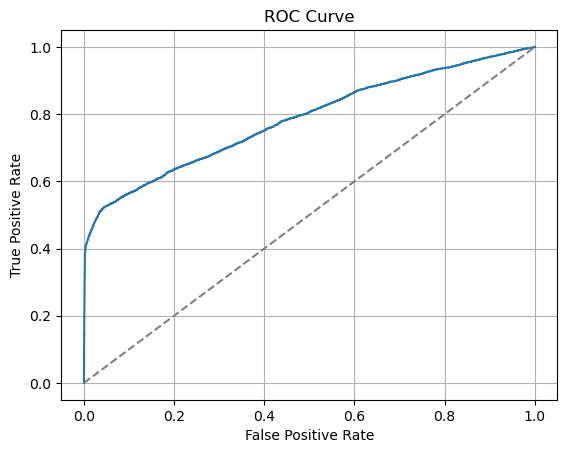

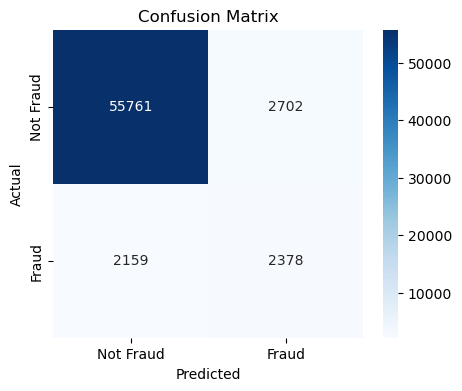

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     58463
           1       0.47      0.52      0.49      4537

    accuracy                           0.92     63000
   macro avg       0.72      0.74      0.73     63000
weighted avg       0.93      0.92      0.92     63000

AUC: 0.7846734121196057


In [9]:
FinalModel=FinalModel(X_train,X_test,y_train,y_test)

## Test walidacji

In [8]:
X_train,y_train=getTestData()
X_test,y_test=getTrainingData()
X_Merged = pd.concat([X_train, X_test]).reset_index(drop=True)
Y_Merged = pd.concat([y_train, y_test]).reset_index(drop=True)

<class 'sklearn.pipeline.Pipeline'>


VotingClassifier(estimators=[('randomforest',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('time_features',
                                                                                TimeTransformer(),
                                                                                ['Transaction.Date',
                                                                                 'Transaction.Hour']),
                                                                               ('high_amount',
                                                                                HighAmountTransformer(),
                                                                                ['Transaction.Amount']),
                                                                               ('numerical',
                                                                                StandardScaler(),
                                                                                ['Transaction.Amount',
                                                                                 'Customer.Age',
                                                                                 'Account.Age.Days',
                                                                                 'Quantity']),
                                                                               ('a...
                                              ('featureselection',
                                               RFE(estimator=LogisticRegression(C=0.1,
                                                                                class_weight='balanced',
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                                   n_features_to_select=18)),
                                              ('model',
                                               LGBMClassifier(colsample_bytree=0.8,
                                                              is_unbalance=True,
                                                              learning_rate=0.01,
                                                              max_depth=2,
                                                              min_split_gain=0.1,
                                                              n_estimators=600,
                                                              random_state=42,
                                                              reg_lambda=1,
                                                              subsample=1,
                                                              verbosity=-1))]))],
                 voting='soft')

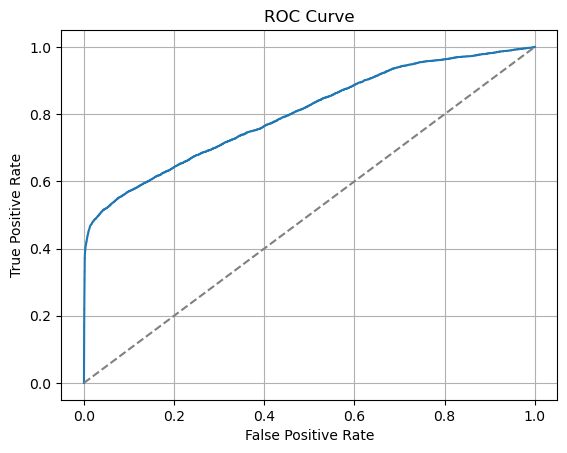

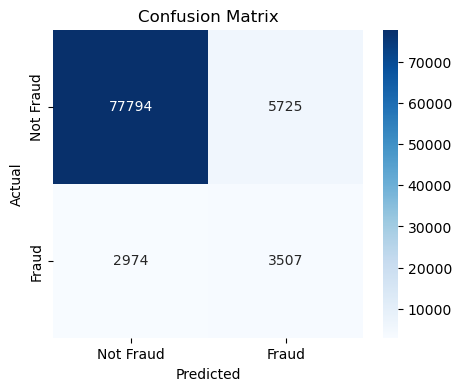

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95     83519
           1       0.38      0.54      0.45      6481

    accuracy                           0.90     90000
   macro avg       0.67      0.74      0.70     90000
weighted avg       0.92      0.90      0.91     90000

AUC: 0.8011064937813845


VotingClassifier(estimators=[('randomforest',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('time_features',
                                                                                TimeTransformer(),
                                                                                ['Transaction.Date',
                                                                                 'Transaction.Hour']),
                                                                               ('high_amount',
                                                                                HighAmountTransformer(),
                                                                                ['Transaction.Amount']),
                                                                               ('numerical',
                                                                                StandardScaler(),
                                                                                ['Transaction.Amount',
                                                                                 'Customer.Age',
                                                                                 'Account.Age.Days',
                                                                                 'Quantity']),
                                                                               ('a...
                                              ('featureselection',
                                               RFE(estimator=LogisticRegression(C=0.1,
                                                                                class_weight='balanced',
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                                   n_features_to_select=18)),
                                              ('model',
                                               LGBMClassifier(colsample_bytree=0.8,
                                                              is_unbalance=True,
                                                              learning_rate=0.01,
                                                              max_depth=2,
                                                              min_split_gain=0.1,
                                                              n_estimators=600,
                                                              random_state=42,
                                                              reg_lambda=1,
                                                              subsample=1,
                                                              verbosity=-1))]))],
                 voting='soft')

In [9]:
X_Validation,Y_Validation=getValidationData()
FinalModel(X_Merged,X_Validation,Y_Merged,Y_Validation,threshold=0.5)

---
## Komentarz walidacji
Model osiąga wysoką ogólną skuteczność (accuracy 92%) i dobrze klasyfikuje klasę większościową.
Skuteczność detekcji fraudów jest jednak dosyć słaba (F1-score dla klasy fraud 0.49),
co wskazuje na problem z balansowaniem klas przy trenowaniu modelu, warto się zastanowić co zrobić by nie było aż takiej "przepaści" między wynikami fraud i not fraud. 
Uzyskana wartość AUC = 0.785 sugeruje, że model ma potencjał, ale wymaga znacznej poprawy jeśli chodzi o balans między klasami.

**Odpowiedź zespołu**: Nie wiemy czemu patrzycie na accuracy, skoro dla naszego celu biznesowego nie ma absolutnie żadnego sensu. Klasyfikacja klasy większościowej nas nie interesuje, liczy się skuteczne wykrywanie klasy mniejszościowej (recall!). Nie uważamy, żeby skuteczność detekcji fraudów była słaba, 50% to dobry wynik jak na uwarunkowanie problemu (połowa fraudów jest wykrywana przy jednoczesnym rzadkim alarmowaniu przy transakcjach fałszywie wykrytych). Trochę większa czułość wiąże się z dużo większą liczbą fałszywie pozytywnych przypadków, czego skrajnie chcieliśmy uniknąć. O jakiej przepaści mówicie? Dysproporcja między fraudami i nie fraudami wynika z tego, że w danych jest 8% fraudów. Nie będziemy sztucznie augmentować danych. M. in. dlatego, że w branży finansowej jest to traktowane dość restrykcyjnie, a w bardzo wielu przypadkach zakazane. 'Model ma potencjał'. No ma, ale co ma do tego balans, nie rozumiemy.